In [14]:
%load_ext autoreload
%autoreload 2

In [1]:
import cvxpy as cp
import numpy as np
from statesim.system.cartpole import CartPole
from statesim.system.inverted_pendulum import InvertedPendulum
from statesim.system.coupled_msd import CoupledMsd
from statesim.model.statespace import Lure
from statesim.simulator import DiscreteSimulator
from statesim.analysis.plot_simulation_results import (
    plot_states,
    plot_outputs,
    plot_inputs,
)
import matplotlib.pyplot as plt
from statesim.analysis.system_analysis import SystemAnalysisContinuous


import matplotlib.pyplot as plt

# init_session(quiet=True)

In [3]:
system = CartPole(mu_p=0.01)
x_bar = np.array([[0], [0], [np.pi], [0]])
A_symb, B_symb = system.get_linearization()
A_c, B_c = system.evaluate_linearization(
    A_sym=A_symb, B_sym=B_symb, x_bar=x_bar, u_bar=np.array([[0]])
)
C_c = np.array([[0, 0, 1, 0]])
D_c = np.array([[0]])
# discretize
eta = 0.001
A_lin = A_c * eta + np.eye(system.nx)
B_lin = B_c * eta

ana = SystemAnalysisContinuous((A_c, B_c, C_c, D_c))
ana.analysis()

Is system stable?: False
H inf norm: inf
Peak gain: 1.1446022383591625
Eigenvalues: [ 0.          0.         -0.16097561 -0.16097561]


In [4]:
# sizes of states, input, outputs
nx = system.nx  # state size of controller is same as state size of plant
nu = (
    system.nx
)  # it is a residual model, the output of the residual needs to have the same dimension as the sate
ny = system.nx
nw = 10
nz = nw  # input to and from uncertainty are equal

In [5]:
# exponential stability no performance channel
X = cp.Variable(shape=(nx, nx), name='X')
Y = cp.Variable(shape=(nx, nx), name='Y')

K = cp.Variable(shape=(nx, nx), name='K')
L1 = cp.Variable(shape=(nx, ny), name='L1')
L2 = cp.Variable(shape=(nx, nw), name='L2')
M1 = cp.Variable(shape=(nu, nx), name='M1')
N11 = cp.Variable(shape=(nu, ny), name='N11')
N12 = cp.Variable(shape=(nu, nw), name='N12')
M2_tilde = cp.Variable(shape=(nz, nx), name='M2_tilde')
N21_tile = cp.Variable(shape=(nz, ny), name='N21_tilde')
N22_tilde = cp.Variable(shape=(nz, nw), name='N22_tilde')
lam = cp.Variable(shape=(nz, 1), pos=True, name='lam')
Lambda = cp.diag(lam)

P_21_1 = cp.bmat(
    [
        [A_lin @ Y, A_lin, np.zeros((nx, nw))],
        [np.zeros((nu, nx)), X @ A_lin, np.zeros((nu, nw))],
        [np.zeros((nz, nx)), np.zeros((nz, ny)), np.zeros((nz, nw))],
    ]
)
P_21_2 = cp.bmat(
    [
        [np.zeros((nx, nx)), A_lin, np.zeros((nx, nz))],
        [np.eye(nx), np.zeros((ny, nu)), np.zeros((ny, nz))],
        [np.zeros((nw, nx)), np.zeros((nw, nu)), np.eye(nz)],
    ]
)
P_21_3 = cp.bmat(
    [[K, L1, L2], [M1, N11, N12], [M2_tilde, N21_tile, N22_tilde]]
)

P_21_4 = cp.bmat(
    [
        [np.zeros((nx, nx)), np.eye(nu), np.zeros((nx, nw))],
        [np.eye(nu), np.zeros((nu, ny)), np.zeros((nu, nw))],
        [np.zeros((nz, nx)), np.zeros((nz, ny)), np.eye(nz)],
    ]
)

P_21 = P_21_1 + P_21_2 @ P_21_3 @ P_21_4
P_11 = -cp.bmat(
    [
        [Y, np.eye(nx), np.zeros((nx, nw))],
        [np.eye(nx), X, np.zeros((nu, nw))],
        [np.zeros((nz, nx)), np.zeros((nz, ny)), Lambda],
    ]
)
P = cp.bmat([[P_11, P_21.T], [P_21, P_11]])

In [6]:
# back transformation to original parameter set
# 1. solve synthesis inequalities to determine X,Y and K,L,M,N, Lambda
t = cp.Variable(shape=1, name='t')
nP = P.shape[0]
objective = cp.Minimize(expr=None)
problem = cp.Problem(
    objective=objective, constraints=[P << -1e-4 * np.eye(nP)]
)
problem.solve(solver=cp.MOSEK)

print(f'problem status: {problem.status}')
print(
    f'Max real eigenvalue of P: {np.max(np.real(np.linalg.eig(P.value)[0]))}'
)

Lambda_inv = np.linalg.inv(Lambda.value)
M2 = Lambda_inv @ M2_tilde.value
N21 = Lambda_inv @ N21_tile.value
N22 = Lambda_inv @ N22_tilde.value

# 2. Determine non-singular U,V with V U^T = I - Y X
U = X.value
V = np.linalg.inv(X.value) - Y.value
# print(V@U.T + Y.value @ X.value)
assert np.linalg.norm(V @ U.T + Y.value @ X.value - np.eye(nx)) < 1e-4

# 3. transform to original parameters
left_mult = np.concatenate(
    [
        np.concatenate([U, X.value @ A_lin, np.zeros((nx, nw))], axis=1),
        np.concatenate(
            [np.zeros((nu, nx)), np.eye(nu), np.zeros((nu, nw))], axis=1
        ),
        np.concatenate(
            [np.zeros((nz, nx)), np.zeros((nz, nu)), np.eye(nw)], axis=1
        ),
    ],
    axis=0,
)
right_mult = np.concatenate(
    [
        np.concatenate([np.zeros((nx, nx)), V.T, np.zeros((nx, nw))], axis=1),
        np.concatenate([np.eye(nx), Y.value, np.zeros((nu, nw))], axis=1),
        np.concatenate(
            [np.zeros((nz, nx)), np.zeros((nz, ny)), np.eye(nw)], axis=1
        ),
    ],
    axis=0,
)
middle = np.concatenate(
    [
        np.concatenate(
            [K.value, L1.value - X.value @ A_lin @ Y.value, L2.value], axis=1
        ),
        np.concatenate([M1.value, N11.value, N12.value], axis=1),
        np.concatenate([M2, N21, N22], axis=1),
    ],
    axis=0,
)
orig_par = np.round(
    np.linalg.inv(left_mult) @ middle @ np.linalg.inv(right_mult), 2
)
print(f'Original parameter shape: {orig_par.shape}')
# print(np.round(orig_par, 2))
A_tilde = orig_par[:nx, :nx]
B2_tilde = orig_par[:nx, nx : nx + ny]
B3_tilde = orig_par[:nx, nx + ny : nx + ny + nw]
C1_tilde = orig_par[nx : nx + nu, :nx]
D12_tilde = orig_par[nx : nx + nu, nx : nx + ny]
D13_tilde = orig_par[nx : nx + nu, nx + ny : nx + ny + nw]
C2 = orig_par[nx + nu : nx + nu + nz, :nx]
D22 = orig_par[nx + nu : nx + nu + nz, nx : nx + ny]
assert np.linalg.norm(orig_par[-nw:-1, -nw:-1]) < 1e-8
print(
    f'A_tilde: {A_tilde} \n B2_tilde: {B2_tilde} \n B3_tilde: {B3_tilde} \n C1_tilde: {C1_tilde} \n D12_tilde: {D12_tilde} \n D13_tilde: {D13_tilde} \n C2: {C2} \n D22: {D22}'
)

problem status: optimal
Max real eigenvalue of P: -3.3313644211218367
Original parameter shape: (18, 18)
A_tilde: [[-0.  0. -0. -0.]
 [ 0. -0. -0.  0.]
 [-0. -0. -0. -0.]
 [ 0.  0. -0. -0.]] 
 B2_tilde: [[-0.  0. -0. -0.]
 [ 0. -0. -0.  0.]
 [-0. -0. -0. -0.]
 [ 0.  0. -0. -0.]] 
 B3_tilde: [[-0. -0. -0. -0. -0.  0. -0. -0. -0. -0.]
 [-0. -0. -0.  0.  0.  0. -0.  0. -0.  0.]
 [-0. -0.  0. -0.  0. -0. -0. -0.  0.  0.]
 [-0. -0.  0. -0.  0.  0. -0. -0.  0.  0.]] 
 C1_tilde: [[ 0. -0.  0.  0.]
 [-0.  0.  0. -0.]
 [ 0.  0.  0.  0.]
 [-0. -0.  0.  0.]] 
 D12_tilde: [[-1. -0.  0.  0.]
 [-0. -1.  0. -0.]
 [ 0.  0. -1.  0.]
 [-0. -0.  0. -1.]] 
 D13_tilde: [[ 0.  0.  0.  0.  0. -0. -0.  0. -0.  0.]
 [ 0.  0.  0. -0. -0. -0.  0. -0.  0. -0.]
 [ 0.  0. -0.  0. -0.  0.  0.  0. -0. -0.]
 [ 0.  0. -0.  0. -0. -0.  0.  0. -0.  0.]] 
 C2: [[ 0. -0.  0. -0.]
 [-0. -0.  0. -0.]
 [ 0.  0. -0.  0.]
 [-0.  0.  0. -0.]
 [-0. -0.  0. -0.]
 [-0. -0.  0. -0.]
 [-0.  0. -0. -0.]
 [-0. -0.  0.  0.]
 [-0. -0.  0

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [-0.  0. -0. -0. -0.  0. -0. -0.]
 [ 0. -0. -0.  0.  0. -0. -0.  0.]
 [-0. -0. -0. -0. -0. -0. -0. -0.]
 [ 0.  0. -0. -0.  0.  0. -0. -0.]]
8


/Users/jack/Documents/python_venv/statesim/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  func(*args, **kwargs)
/Users/jack/Documents/python_venv/statesim/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


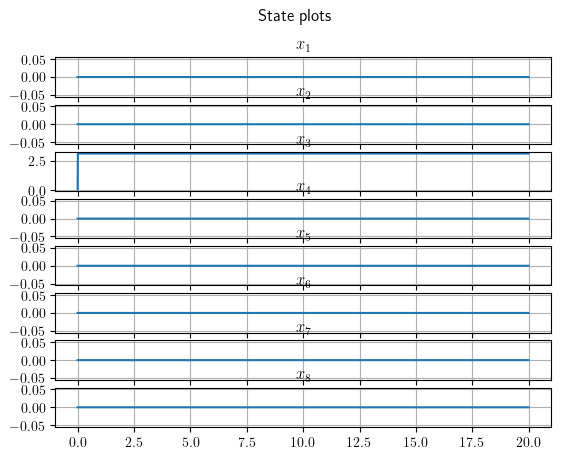

In [7]:
# create closed loop system and simulate
nwp = 1
nzp = 1

beta = 1
alpha = 0
Delta = lambda z: np.tanh(z)
Delta_tilde = lambda z: (2 / beta - alpha) * (
    Delta(z) - ((alpha + beta) / 2) * z
)
A_cal = np.concatenate(
    [
        np.concatenate([A_lin + A_lin @ D12_tilde, A_lin @ C1_tilde], axis=1),
        np.concatenate([B2_tilde, A_tilde], axis=1),
    ],
    axis=0,
)
B2_cal = np.concatenate([A_lin @ D13_tilde, B3_tilde], axis=0)
C2_cal = np.concatenate([D22, C2], axis=1)
D22_cal = np.zeros(shape=(nw, nw))
B1_cal = np.zeros(shape=(2 * nx, nwp))
C1_cal = np.zeros(shape=(nzp, 2 * nx))
D11_cal = np.zeros(shape=(nzp, nwp))
D12_cal = np.zeros(shape=(nzp, nw))
D21_cal = np.zeros(shape=(nz, nwp))

print(A_cal)

model = Lure(
    A=A_cal,
    B1=B1_cal,
    B2=B2_cal,
    C1=C1_cal,
    D11=D11_cal,
    D12=D12_cal,
    C2=C2_cal,
    D21=D21_cal,
    Delta=Delta_tilde,
)
print(model._nx)
T = 20
step_size = 0.01
N = int(T / step_size)
sim = DiscreteSimulator(
    T=T,
    step_size=step_size,
)
x0 = np.zeros(shape=(2 * nx, 1))
x0[2, 0] = 0.1
x_bar = np.zeros(shape=(2 * nx, 1))
x_bar[2, 0] = np.pi
res = sim.simulate(
    model=model,
    initial_state=x0,
    input=[np.array([[u]]) for u in np.zeros(shape=(N, 1))],
    x_bar=x_bar,
)
plot_states(result=res)